<a href="https://colab.research.google.com/github/RSBalchII/cohort-15-data-science/blob/main/Project_2_Housing_Price_Prediction_v_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Housing Price Prediction


The primary objective of this project is to investigate the relationship between various housing characteristics and their sale prices. We aim to address two main points:

Determine the extent to which the provided housing variables correlate with and can predict house prices.

Assess whether the available data can effectively explain house price variations or if external factors not captured in the dataset might have a more significant influence on pricing.

Key Questions:

Which housing features, if any, demonstrate strong correlations with sale prices?
Can we build a reliable predictive model for house prices using only the provided housing characteristics?
How well do our models perform in terms of accuracy (RMSPE) and explanatory power (R-squared)?
Are there indications that factors outside of our dataset might be playing a crucial role in determining house prices?
By addressing these questions, we seek to understand the predictive power of the available housing data and potentially uncover limitations in using solely these variables to explain house price variations. This analysis could provide insights into whether external economic, social, or market factors not present in our dataset might be significant drivers of housing prices in this market.

The data is available on AWS S3 at https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv .

A data dictionary file is available at AWS S3 at [Housing Data Dictionary]( https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf ).

## Install Nvidia cudf dependencies and package

In [96]:
# %%capture
# !pip install cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
# !apt-get update
# !apt-get install -y nvidia-cuda-toolkit

# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

# %load_ext cudf.pandas

In [97]:
# get_ipython().kernel.do_shutdown(restart=True)

A data dictionary file is available at AWS S3 at [Housing Data Dictionary]( https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf ).

## 1- Imports

In [98]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler


# 2- Loading the Data

In [99]:
# Load the data
url = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv'
df = pd.read_csv(url)

# 3- Create Data Frame

In [100]:
df_1 = pd.DataFrame(df)
df_1

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,903231070,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,400,9,2006,WD,Normal,114500
2633,906201021,80,RL,74.0,10778,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,162000
2634,533253070,120,RL,61.0,3782,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,211500
2635,527376100,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,165000


## Determine the "target"

In [101]:
# Identify the target variable (SalePrice)
target = df_1['SalePrice'].copy()

### Determining data distinctions

In [102]:
# Identify categorical columns
categorical_cols = df_1.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'Categorical columns{categorical_cols}')

# Identify numerical columns
numerical_cols = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'\nNumerical columns{numerical_cols}')



Categorical columns['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type', 'Sale Condition']

Numerical columns['PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen A

### Asses Unique Values

In [103]:
for col in categorical_cols:
    unique_values = df_1[col].unique()
    print(f"Unique values in column '{col}': {unique_values}")

Unique values in column 'MS Zoning': ['RL' 'RM' 'FV' 'C (all)' 'RH' 'I (all)' 'A (agr)']
Unique values in column 'Street': ['Pave' 'Grvl']
Unique values in column 'Alley': [nan 'Pave' 'Grvl']
Unique values in column 'Lot Shape': ['Reg' 'IR1' 'IR2' 'IR3']
Unique values in column 'Land Contour': ['Lvl' 'Bnk' 'HLS' 'Low']
Unique values in column 'Utilities': ['AllPub' 'NoSewr' 'NoSeWa']
Unique values in column 'Lot Config': ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Unique values in column 'Land Slope': ['Gtl' 'Mod' 'Sev']
Unique values in column 'Neighborhood': ['Sawyer' 'IDOTRR' 'Somerst' 'SWISU' 'CollgCr' 'Edwards' 'OldTown'
 'Mitchel' 'NridgHt' 'ClearCr' 'NWAmes' 'Gilbert' 'NoRidge' 'NAmes'
 'Timber' 'MeadowV' 'StoneBr' 'Blmngtn' 'SawyerW' 'Crawfor' 'Veenker'
 'BrkSide' 'GrnHill' 'BrDale' 'NPkVill' 'Greens' 'Blueste' 'Landmrk']
Unique values in column 'Condition 1': ['Feedr' 'Norm' 'PosA' 'RRAn' 'PosN' 'Artery' 'RRNn' 'RRAe' 'RRNe']
Unique values in column 'Condition 2': ['Norm' 'RRNn'

### **Zacs**

In [104]:
# B =['Street']
# A = ['Alley']
# merged_df = pd.merge(
#     categorical_cols[A + B].value_counts(dropna = True).reset_index() ,
#     categorical_cols[B].value_counts(dropna = True).reset_index(),
#     on = B
#   )
# merged_df['marg_prob'] = merged_df['count_x']/merged_df['count_y'] * 100
# merged_df

### Mels


In [105]:
# pairs = ['Street', 'Heating']
# house_orig[pairs].value_counts()/house_orig[pairs].value_counts().sum()*100

### Minervas marginal Probability ex.

##### for col in categorical_cols:
```
for col in categorical_cols:
  print(categorical_cols[col].value_counts() /categorical_cols[col].notna().sum()*100 , '\n')
  ```

## Adapted marginal Probability for my setup

In [106]:
# Print value counts and percentages for each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize=True) * 100)



Column: MS Zoning
MS Zoning
RL         77.474403
RM         15.889268
FV          4.664391
C (all)     0.948047
RH          0.872203
I (all)     0.075844
A (agr)     0.075844
Name: proportion, dtype: float64

Column: Street
Street
Pave    99.544937
Grvl     0.455063
Name: proportion, dtype: float64

Column: Alley
Alley
Grvl    61.666667
Pave    38.333333
Name: proportion, dtype: float64

Column: Lot Shape
Lot Shape
Reg    63.026166
IR1    33.940083
IR2     2.464922
IR3     0.568828
Name: proportion, dtype: float64

Column: Land Contour
Land Contour
Lvl    89.685248
HLS     4.209329
Bnk     4.019719
Low     2.085703
Name: proportion, dtype: float64

Column: Utilities
Utilities
AllPub    99.886234
NoSewr     0.075844
NoSeWa     0.037922
Name: proportion, dtype: float64

Column: Lot Config
Lot Config
Inside     72.961699
Corner     17.406143
CulDSac     6.067501
FR2         3.071672
FR3         0.492984
Name: proportion, dtype: float64

Column: Land Slope
Land Slope
Gtl    95.221843
Mod 

### Examination of categorical variables

In [107]:
# Examine categorical variables
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {len(df_1[col].unique())}")
    print(f"Most common values:")
    print(df_1[col].value_counts(normalize=True).head())

    # Check if the column has too many unique values
    if len(df_1[col]) > 50:
        print(f"Warning: {col} has more than 50 unique values")

    # Check if the column is highly imbalanced
    if df_1[col].value_counts(normalize=True).max() > 0.95:
        print(f"Warning: {col} is highly imbalanced")



Column: MS Zoning
Number of unique values: 7
Most common values:
MS Zoning
RL         0.774744
RM         0.158893
FV         0.046644
C (all)    0.009480
RH         0.008722
Name: proportion, dtype: float64

Column: Street
Number of unique values: 2
Most common values:
Street
Pave    0.995449
Grvl    0.004551
Name: proportion, dtype: float64

Column: Alley
Number of unique values: 3
Most common values:
Alley
Grvl    0.616667
Pave    0.383333
Name: proportion, dtype: float64

Column: Lot Shape
Number of unique values: 4
Most common values:
Lot Shape
Reg    0.630262
IR1    0.339401
IR2    0.024649
IR3    0.005688
Name: proportion, dtype: float64

Column: Land Contour
Number of unique values: 4
Most common values:
Land Contour
Lvl    0.896852
HLS    0.042093
Bnk    0.040197
Low    0.020857
Name: proportion, dtype: float64

Column: Utilities
Number of unique values: 3
Most common values:
Utilities
AllPub    0.998862
NoSewr    0.000758
NoSeWa    0.000379
Name: proportion, dtype: float64



#

# 4- Data Cleaning

### isolate Float64 data columns

In [108]:
# Get the names of the float columns
float_columns = df_1.select_dtypes(include=['float64']).columns

# Select the float columns from df_1
df_float = df_1[float_columns]

df_float_1 = df_float.copy()

df_float_1.describe()

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
count,2188.000000,2614.000000,2636.000000,2636.000000,2636.000000,2636.000000,2635.000000,2635.000000,2490.000000,2636.000000,2636.000000
mean,69.166819,101.887911,438.441199,51.068665,555.669196,1045.179059,0.432258,0.058824,1978.185944,1.763278,470.968134
std,23.356779,179.578232,449.602326,172.521803,436.223188,429.686089,0.525239,0.240130,25.452647,0.760576,212.816905
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,218.000000,792.000000,0.000000,0.000000,1961.000000,1.000000,324.750000
50%,68.000000,0.000000,368.000000,0.000000,464.500000,988.000000,0.000000,0.000000,1979.000000,2.000000,480.000000
75%,80.000000,164.000000,732.000000,0.000000,797.250000,1290.250000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,313.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000


### Cleaning null values

In [109]:

# Check for missing values
print(df_float_1.isnull().sum())

Lot Frontage      449
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Yr Blt     147
Garage Cars         1
Garage Area         1
dtype: int64


### dropping Lot Frontage with high number of null values

In [110]:

# Remove 'Lot Frontage' column
df_float_1 = df_float_1.drop('Lot Frontage', axis=1)

# Check for missing values
print(df_float_1.isnull().sum())

Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Yr Blt     147
Garage Cars         1
Garage Area         1
dtype: int64


### Imputing data for the remainder of columns using looping method

In [111]:
# Replace missing values with the mean of each column
for col in df_float_1.columns:
    df_float_1[col] = df_float_1[col].fillna(df_float_1[col].mean())

# Verify that there are no more missing values
print(df_float_1.isnull().sum())

Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
Garage Cars       0
Garage Area       0
dtype: int64


In [112]:
features_for_correlation = df_float_1.copy()

### preparing cleaned feature data for feature correlation

In [113]:
# Ensure SalePrice is in df_1
if 'SalePrice' not in df_1:
    print("SalePrice not found in df_1. Please check your data.")
else:
    # Concatenate df_float_1 with SalePrice
    features_for_correlation['SalePrice'] = df_1['SalePrice']

# Print the shape of the updated dataframe
print(f"Shape of df_float_1 after adding SalePrice: {features_for_correlation.shape}")

# Print the columns of df_float_1
print("Columns in features_for_correlation")
print(features_for_correlation.columns)

Shape of df_float_1 after adding SalePrice: (2637, 11)
Columns in features_for_correlation
Index(['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')


# 5aa- Feature Selection / EDA

### Initial Correlation Visualization of remaining features

Top 5 features correlated with SalePrice:
SalePrice         1.000000
Garage Cars       0.647207
Garage Area       0.633883
Total Bsmt SF     0.628470
Garage Yr Blt     0.512310
Mas Vnr Area      0.503488
BsmtFin SF 1      0.427674
Bsmt Full Bath    0.277146
Bsmt Unf SF       0.174573
Bsmt Half Bath    0.042454
Name: SalePrice, dtype: float64


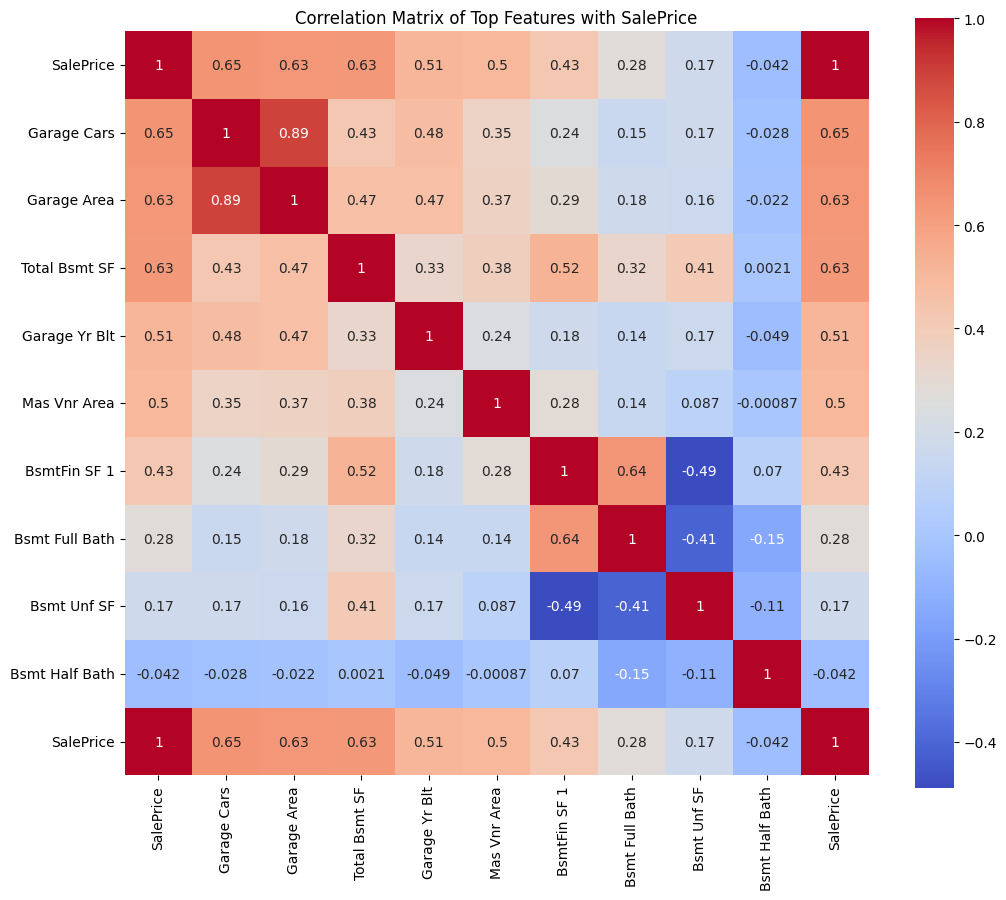

In [114]:
# Calculate correlation matrix
corr_matrix = features_for_correlation.corr()

# Extract correlations with SalePrice
saleprice_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)

# Print the top 10 most correlated features with SalePrice
print("Top 5 features correlated with SalePrice:")
print(saleprice_corr.head(10))

# Create a heatmap of the top 10 correlated features
top_features = saleprice_corr.index[:10].tolist()
top_features.append('SalePrice')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Top Features with SalePrice')
plt.show()

### Feature Selection based on correlation

In [115]:
# Print the top 10 most correlated features with SalePrice
print("Top 10 features correlated with SalePrice:")
print(saleprice_corr.head(11))


Top 10 features correlated with SalePrice:
SalePrice         1.000000
Garage Cars       0.647207
Garage Area       0.633883
Total Bsmt SF     0.628470
Garage Yr Blt     0.512310
Mas Vnr Area      0.503488
BsmtFin SF 1      0.427674
Bsmt Full Bath    0.277146
Bsmt Unf SF       0.174573
Bsmt Half Bath    0.042454
BsmtFin SF 2      0.009326
Name: SalePrice, dtype: float64


In [116]:
# Select features with correlation > 0.5
selected_features = saleprice_corr[saleprice_corr > 0.5].index.tolist()

In [117]:
# Remove 'SalePrice' from the list if it exists
if 'SalePrice' in selected_features:
    selected_features.remove('SalePrice')

# Print selected features
print("\nSelected features (correlation > 0.5):")
print(selected_features)


Selected features (correlation > 0.5):
['Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Garage Yr Blt', 'Mas Vnr Area']


In [118]:
# Create a new dataframe with selected features
corr_features = features_for_correlation[selected_features].copy()

In [119]:

# Print the shape of the new dataframe
print(f"\nShape of selected features dataframe: {corr_features.shape}")


Shape of selected features dataframe: (2637, 5)


# 5bb- Data Preparation

In [120]:
# Print the shape of features and target
print(f"Features shape: {corr_features.shape}")
print(f"Target shape: {target.shape}")

Features shape: (2637, 5)
Target shape: (2637,)


### Splitting Training and Testing sets

In [121]:
# Data Preparation
X_train, X_test, y_train, y_test = train_test_split(corr_features, target, test_size=0.2, random_state=42)


In [122]:
# Print the shapes of the split data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2109, 5)
X_test shape: (528, 5)
y_train shape: (2109,)
y_test shape: (528,)


## Feature Scaling for corr_features

In [123]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5b- Feature Selection / EDA corr_features_2

In [124]:
# Identify integer features without null values
int_features = df.select_dtypes(include=['int64']).columns.tolist()
non_null_int_features = [col for col in int_features if df[col].isnull().sum() == 0]

# Remove PID from non_null_int_features if it exists
if 'PID' in non_null_int_features:
    non_null_int_features.remove('PID')

# Create a new dataframe with selected features and non-null integer features
corr_features_2 = pd.concat([corr_features, df[non_null_int_features]], axis=1)

# Print the shape of the new dataframe
print(f"\nShape of corr_features_2 dataframe: {corr_features_2.shape}")

# Print the columns of the new dataframe
print("\nColumns in corr_features_2:")
print(corr_features_2.columns.tolist())

# Remove 'SalePrice' from corr_features_2 if it exists
if 'SalePrice' in corr_features_2.columns:
    corr_features_2 = corr_features_2.drop('SalePrice', axis=1)

# Print the updated shape and columns
print(f"\nUpdated shape of corr_features_2 dataframe: {corr_features_2.shape}")
print("\nUpdated columns in corr_features_2:")
print(corr_features_2.columns.tolist())

# Separate features and target
features = corr_features_2

# Print the shape of features and target
print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}")



Shape of corr_features_2 dataframe: (2637, 31)

Columns in corr_features_2:
['Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Garage Yr Blt', 'Mas Vnr Area', 'MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']

Updated shape of corr_features_2 dataframe: (2637, 30)

Updated columns in corr_features_2:
['Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Garage Yr Blt', 'Mas Vnr Area', 'MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclo

# 5b- Feature Scaling

In [125]:
# Update the train-test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(corr_features_2, target, test_size=0.2, random_state=42)



In [126]:
# Print the shapes of the split data
print(f"\nX_train_2 shape: {X_train_2.shape}")
print(f"X_test_2 shape: {X_test_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")
print(f"y_test_2 shape: {y_test_2.shape}")


X_train_2 shape: (2109, 30)
X_test_2 shape: (528, 30)
y_train_2 shape: (2109,)
y_test_2 shape: (528,)


In [127]:
# Feature Scaling for corr_features_2
scaler_2 = StandardScaler()
X_train_scaled_2 = scaler_2.fit_transform(X_train_2)
X_test_scaled_2 = scaler_2.transform(X_test_2)

# 5a-1 Ridge Modelling

Root Mean Squared Error (RMSE): $48960.63
Root Mean Squared Percentage Error (RMSPE): 3.38%
R-squared: 0.6528


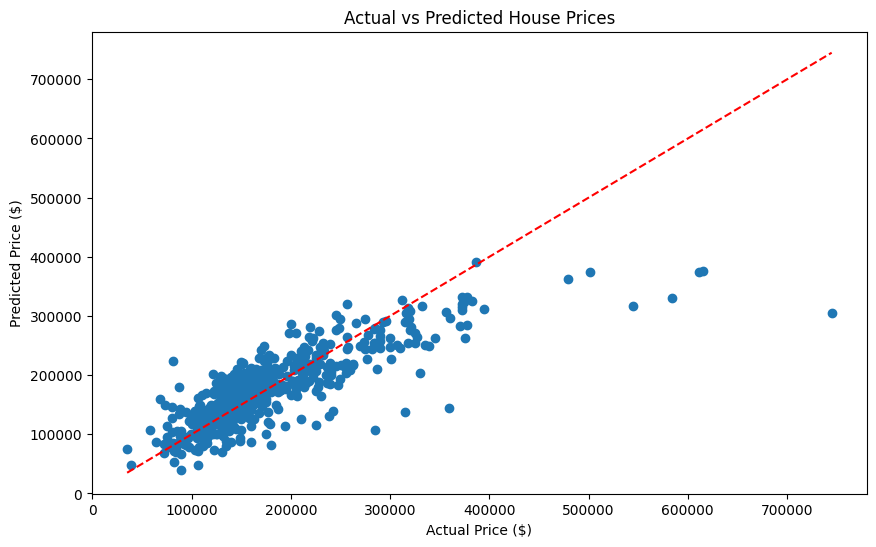

In [128]:
# Model Creation and Evaluation
# Use Ridge regression with a small alpha value to add some regularization
model = Ridge(alpha=0.1)
model.fit(X_train_scaled, y_train)

# Make predictions
predictions = model.predict(X_test_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

rmspe = np.sqrt(np.mean((predictions - y_test) / y_test)**2) * 100
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")

r2 = model.score(X_test_scaled, y_test)
print(f"R-squared: {r2:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()


## Ridge qq Plotting

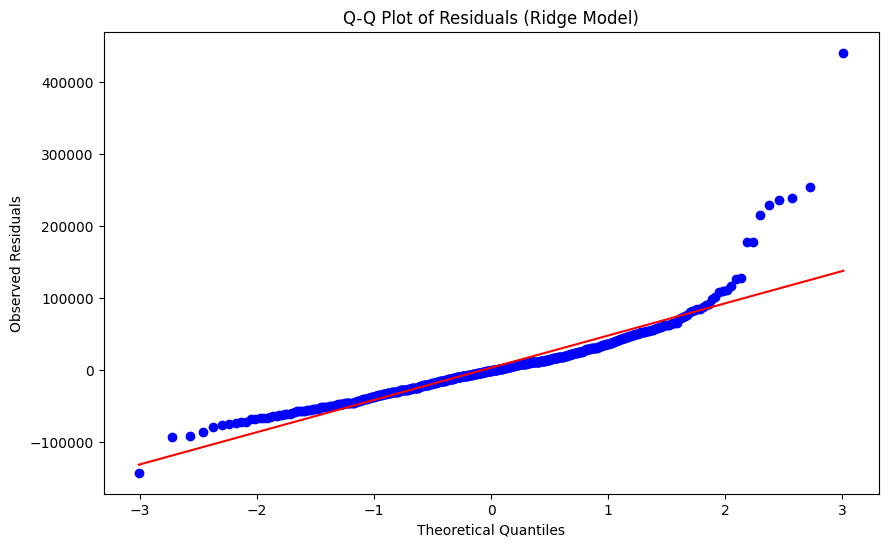

In [129]:
# Q-Q plot for Ridge model residuals
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Ridge Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# 5b-1 RFE Modelling


RMSE of RFE-selected Random Forest Model: $52172.56
Root Mean Squared Percentage Error (RMSPE): 3.77%
R-squared: 0.6058


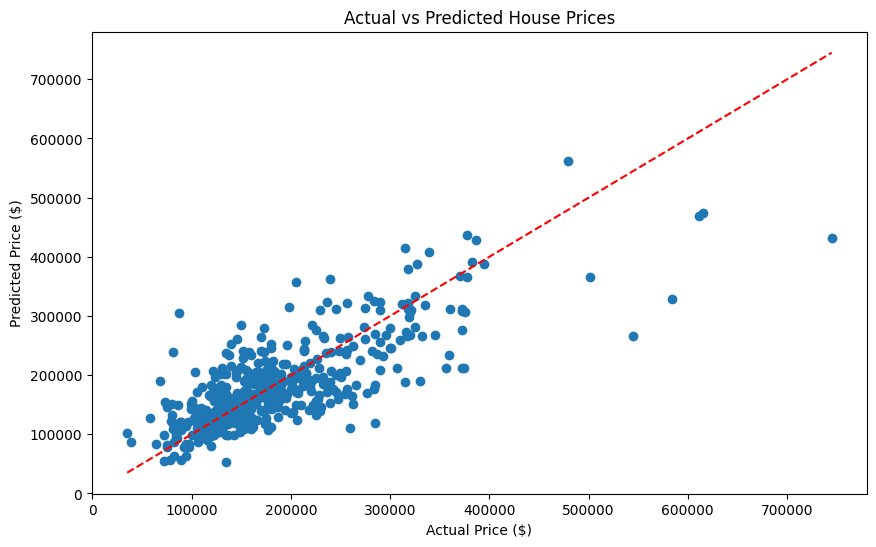

In [130]:
# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Create RFE object with 11 features to select
rfe = RFE(estimator=rf_regressor)

# Fit the RFE model using scaled data
rfe.fit(X_train_scaled, y_train)

# Create a new Random Forest Regressor model using only the selected features
new_rf_model = RandomForestRegressor(n_estimators=100)

# Fit the new model on the selected features
X_train_selected_scaled = X_train_scaled[:, rfe.support_]
new_rf_model.fit(X_train_selected_scaled, y_train)

# Evaluate our new model:
# Make predictions on the test set
X_test_selected_scaled = X_test_scaled[:, rfe.support_]
y_pred = new_rf_model.predict(X_test_selected_scaled)
corr_features_2
# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE of RFE-selected Random Forest Model: ${rmse:.2f}")

# Calculate RMSPE
rmspe = np.sqrt(np.mean((y_pred - y_test) / y_test)**2) * 100
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")

# Calculate R-squared
r2 = new_rf_model.score(X_test_selected_scaled, y_test)
print(f"R-squared: {r2:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()


## RFE Q-Q Plotting

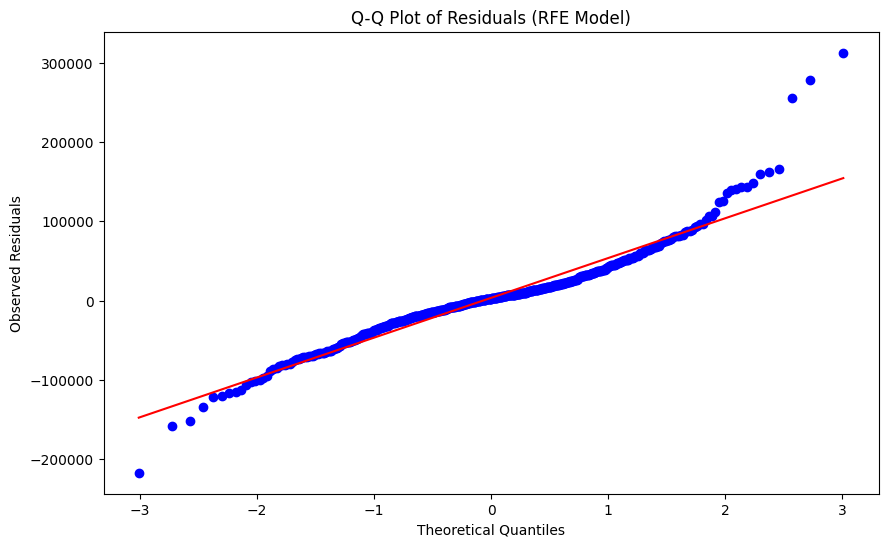

In [131]:
# Q-Q plot for RFE model residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (RFE Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# 5c-1 RFECV Modelling


Selected features by RFECV: Index(['Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Garage Yr Blt',
       'Mas Vnr Area'],
      dtype='object')

Optimal number of features: 5


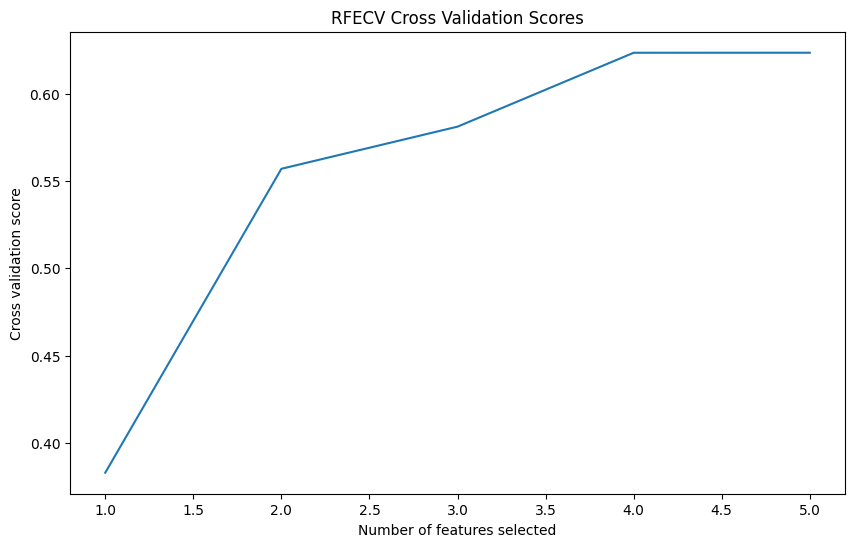

RMSE of RFECV-selected Linear Regression Model: $48960.42
Root Mean Squared Percentage Error (RMSPE): 3.38%
R-squared: 0.6528


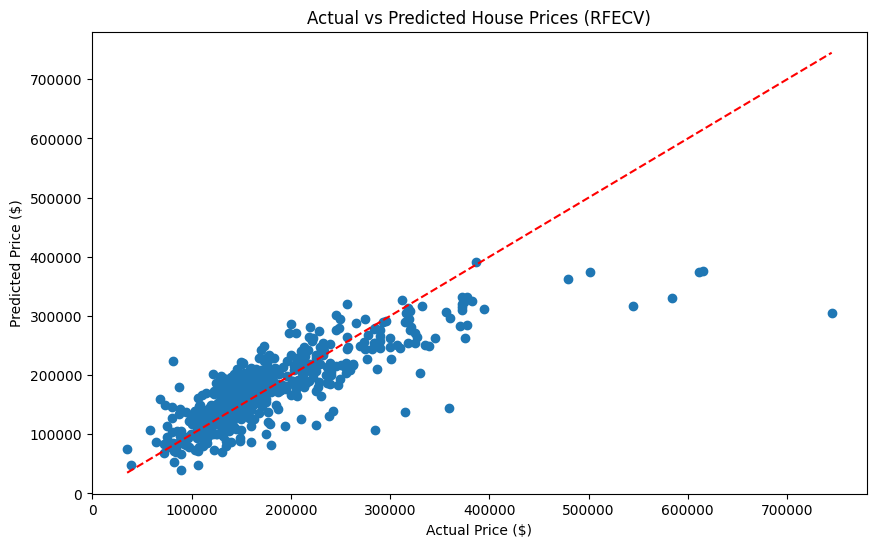

In [132]:
# Create a linear regression model
model = LinearRegression()

# Create an RFECV object
rfecv = RFECV(estimator=model, step=1, cv=5)

# Fit the RFECV object
rfecv.fit(X_train_scaled, y_train)

# Get the selected features
selected_features_rfecv = corr_features.columns[rfecv.support_]
print("\nSelected features by RFECV:", selected_features_rfecv)

# Print the optimal number of features
print(f"\nOptimal number of features: {rfecv.n_features_}")

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("RFECV Cross Validation Scores")
plt.show()

# Transform the data using the selected features
X_train_selected_scaled = rfecv.transform(X_train_scaled)
X_test_selected_scaled = rfecv.transform(X_test_scaled)

# Create and fit a new model using the selected features
new_model = LinearRegression()
new_model.fit(X_train_selected_scaled, y_train)

# Evaluate the new model
y_pred = new_model.predict(X_test_selected_scaled)

# Calculate metrics
mse = np.mean((y_pred - y_test)**2)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean((y_pred - y_test) / y_test)**2) * 100
r2 = new_model.score(X_test_selected_scaled, y_test)

print(f"RMSE of RFECV-selected Linear Regression Model: ${rmse:.2f}")
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")
print(f"R-squared: {r2:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices (RFECV)')
plt.show()

## RFECV Q-Q Plotting

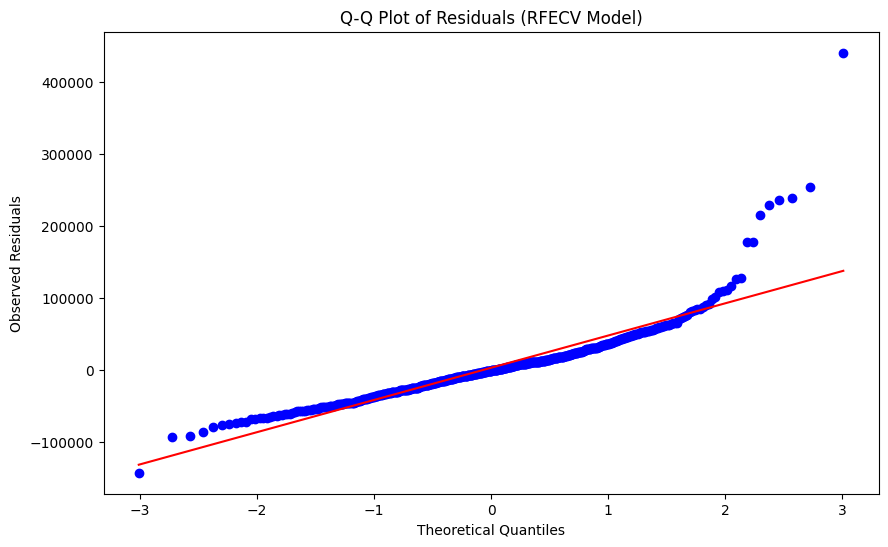

In [133]:
# Q-Q plot for RFECV model residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (RFECV Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# Lasso Regression Modelling

Lasso Regression Metrics:
RMSE: $48996.85
RMSPE: 3.46%
R-squared: 0.6523


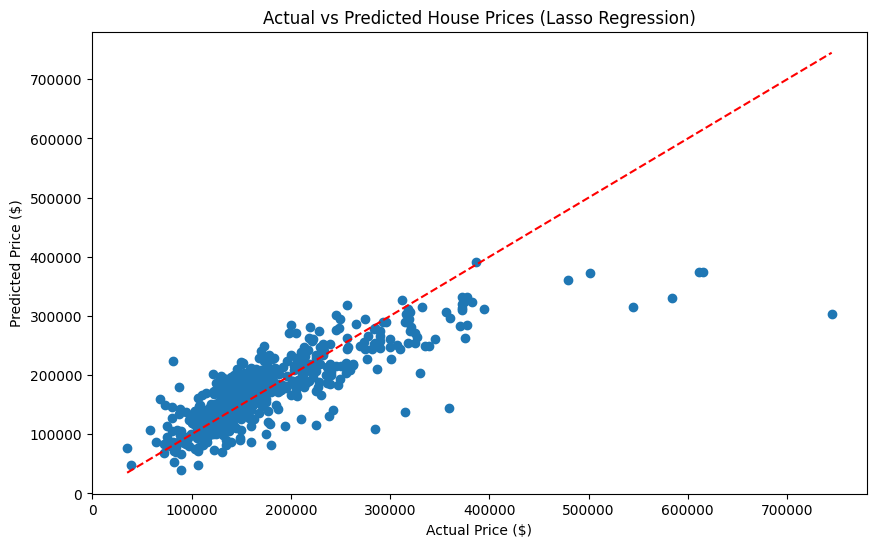

In [134]:
# Perform Lasso regression
lasso_model = LassoCV(cv=5, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
rmspe = np.sqrt(np.mean((y_pred_lasso - y_test) / y_test)**2) * 100
r2 = lasso_model.score(X_test_scaled, y_test)

print(f"Lasso Regression Metrics:")
print(f"RMSE: ${rmse:.2f}")
print(f"RMSPE: {rmspe:.2f}%")
print(f"R-squared: {r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices (Lasso Regression)')
plt.show()

## Lasso Q-Q plotting

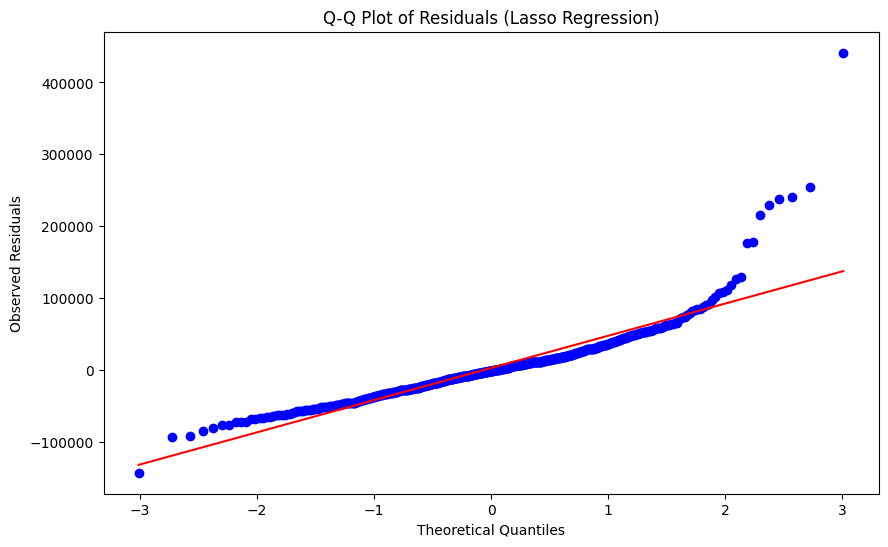

In [135]:
# Q-Q plot for Lasso model residuals
residuals = y_test - y_pred_lasso
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Lasso Regression)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# 5a-2 Ridge Modelling

Root Mean Squared Error (RMSE): $34616.82
Root Mean Squared Percentage Error (RMSPE): 0.04%
R-squared: 0.8264


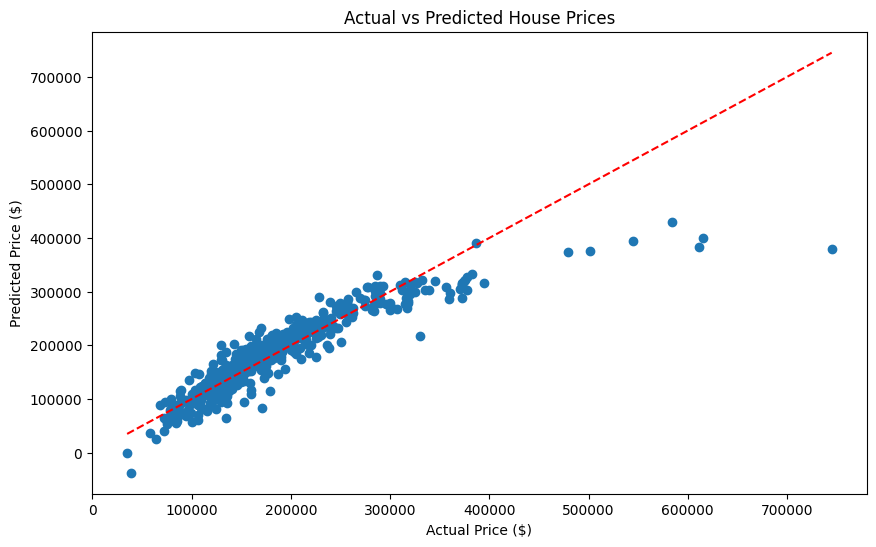

In [136]:
# Feature Scaling for corr_features_2
scaler_2 = StandardScaler()
X_train_scaled_2 = scaler_2.fit_transform(X_train_2)
X_test_scaled_2 = scaler_2.transform(X_test_2)

# Model Creation and Evaluation
# Use Ridge regression with a small alpha value to add some regularization
model = Ridge(alpha=0.1)
model.fit(X_train_scaled_2, y_train_2)

# Make predictions
predictions = model.predict(X_test_scaled_2)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_2, predictions))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

rmspe = np.sqrt(np.mean((predictions - y_test_2) / y_test_2)**2) * 100
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")

r2 = model.score(X_test_scaled_2, y_test_2)
print(f"R-squared: {r2:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, predictions)
plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()


## Ridge Q-Q Plotting

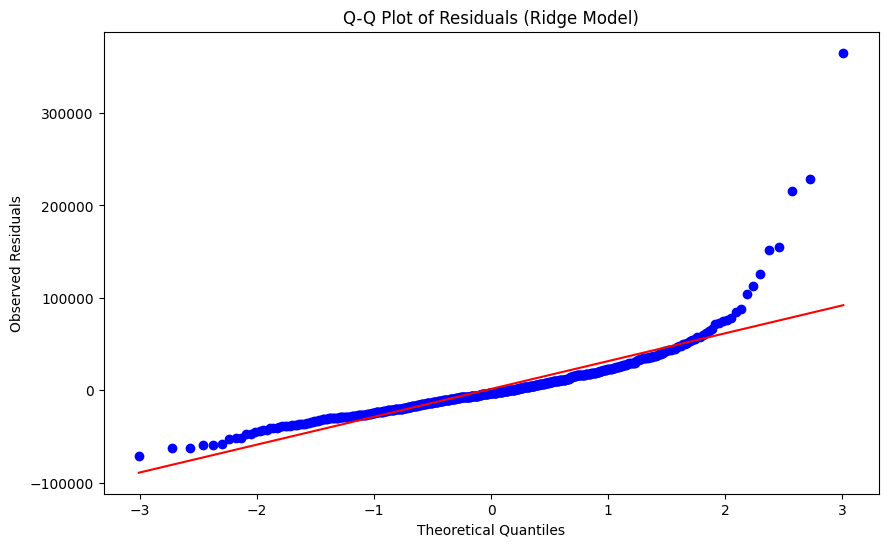

In [137]:
# Q-Q plot for Ridge model residuals
residuals = y_test_2 - predictions
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Ridge Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# 5b-2 RFE Modelling

RMSE of RFE-selected Random Forest Model: $29558.76
Root Mean Squared Percentage Error (RMSPE): 1.97%
R-squared: 0.8735


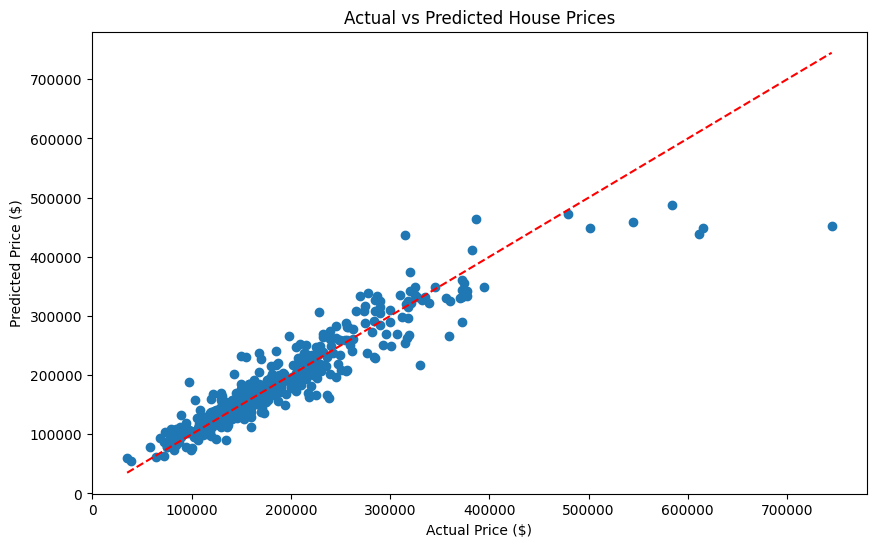

In [138]:
# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Create RFE object with 11 features to select
rfe = RFE(estimator=rf_regressor)

# Fit the RFE model using scaled data
rfe.fit(X_train_scaled_2, y_train_2)

# Create a new Random Forest Regressor model using only the selected features
new_rf_model = RandomForestRegressor(n_estimators=100)

# Fit the new model on the selected features
X_train_selected_scaled_2 = X_train_scaled_2[:, rfe.support_]
new_rf_model.fit(X_train_selected_scaled_2, y_train_2)

# Evaluate our new model:
# Make predictions on the test set
X_test_selected_scaled_2 = X_test_scaled_2[:, rfe.support_]
y_pred = new_rf_model.predict(X_test_selected_scaled_2)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test_2, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE of RFE-selected Random Forest Model: ${rmse:.2f}")

# Calculate RMSPE
rmspe = np.sqrt(np.mean((y_pred - y_test_2) / y_test_2)**2) * 100
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")

# Calculate R-squared
r2 = new_rf_model.score(X_test_selected_scaled_2, y_test_2)
print(f"R-squared: {r2:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, y_pred)
plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()

## RFE Q-Q Plotting

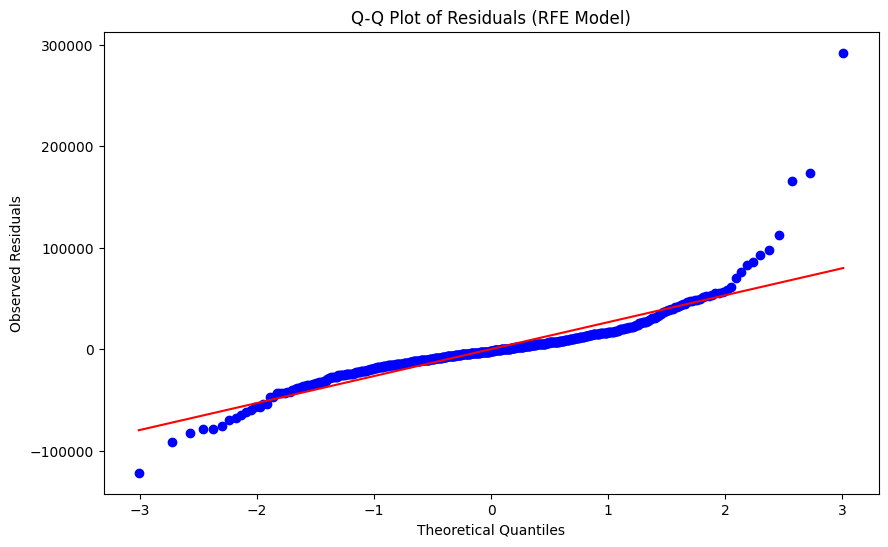

In [139]:
# Q-Q plot for RFE model residuals
residuals = y_test_2 - y_pred
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (RFE Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# 5c-2 RFECV Modelling


Selected features by RFECV: Index(['Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Garage Yr Blt',
       'Mas Vnr Area', 'MS SubClass', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold',
       'Yr Sold'],
      dtype='object')

Optimal number of features: 30


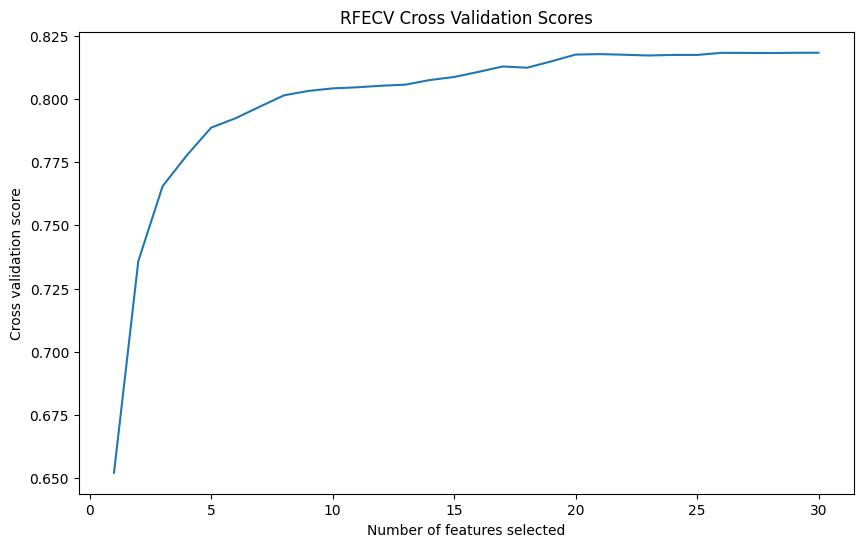

RMSE of RFECV-selected Linear Regression Model: $34633.03
Root Mean Squared Percentage Error (RMSPE): 0.05%
R-squared: 0.8263


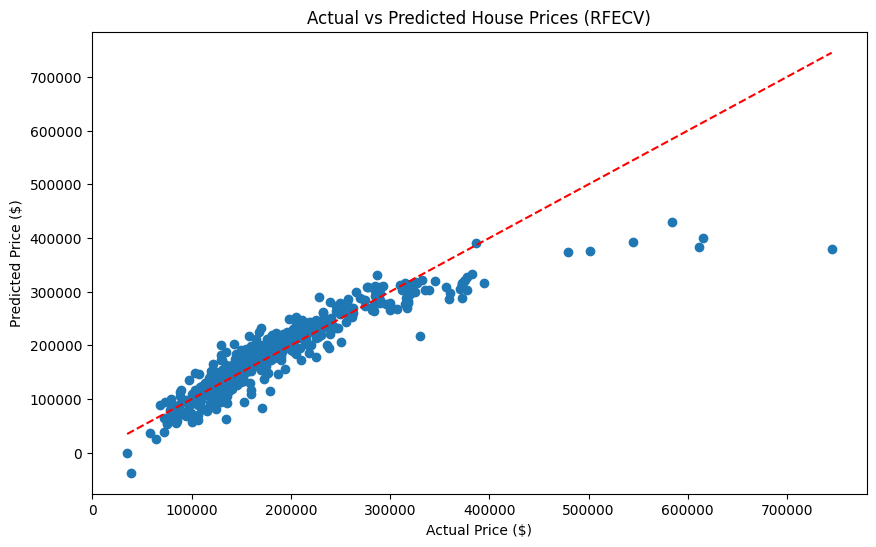

In [140]:
# Create a linear regression model
model = LinearRegression()

# Create an RFECV object
rfecv = RFECV(estimator=model, step=1, cv=5)

# Fit the RFECV object
rfecv.fit(X_train_scaled_2, y_train_2)

# Get the selected features
selected_features_rfecv = corr_features_2.columns[rfecv.support_]
print("\nSelected features by RFECV:", selected_features_rfecv)

# Print the optimal number of features
print(f"\nOptimal number of features: {rfecv.n_features_}")

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("RFECV Cross Validation Scores")
plt.show()

# Transform the data using the selected features
X_train_selected_scaled_2 = rfecv.transform(X_train_scaled_2)
X_test_selected_scaled_2 = rfecv.transform(X_test_scaled_2)

# Create and fit a new model using the selected features
new_model = LinearRegression()
new_model.fit(X_train_selected_scaled_2, y_train_2)

# Evaluate the new model5
y_pred = new_model.predict(X_test_selected_scaled_2)

# Calculate metrics
mse = np.mean((y_pred - y_test_2)**2)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean((y_pred - y_test_2) / y_test_2)**2) * 100
r2 = new_model.score(X_test_selected_scaled_2, y_test_2)

print(f"RMSE of RFECV-selected Linear Regression Model: ${rmse:.2f}")
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")
print(f"R-squared: {r2:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, y_pred)
plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices (RFECV)')
plt.show()

## RFECV qq Plotting

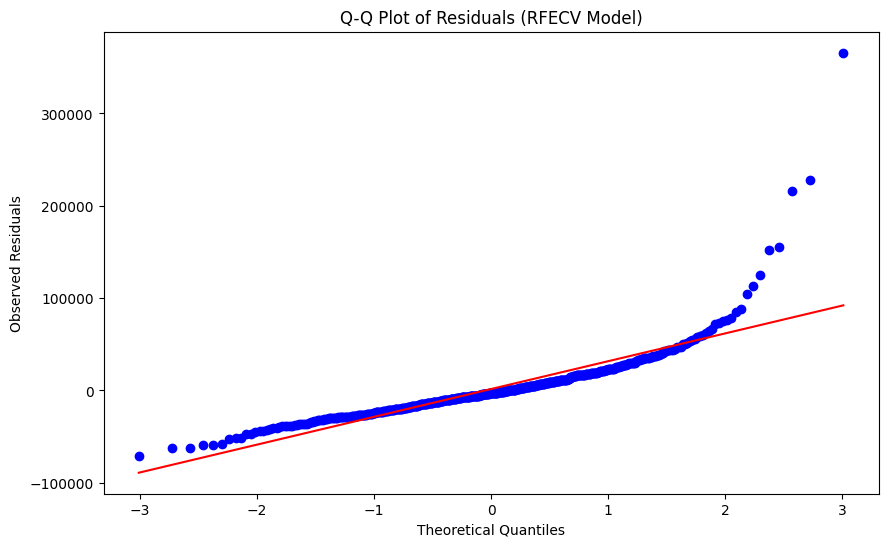

In [141]:
qq
plt.title('Q-Q Plot of Residuals (RFECV Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# Lasso Regression Modelling

Lasso Regression Metrics (Second Round):
RMSE: $34537.16
RMSPE: 0.25%
R-squared: 0.8272


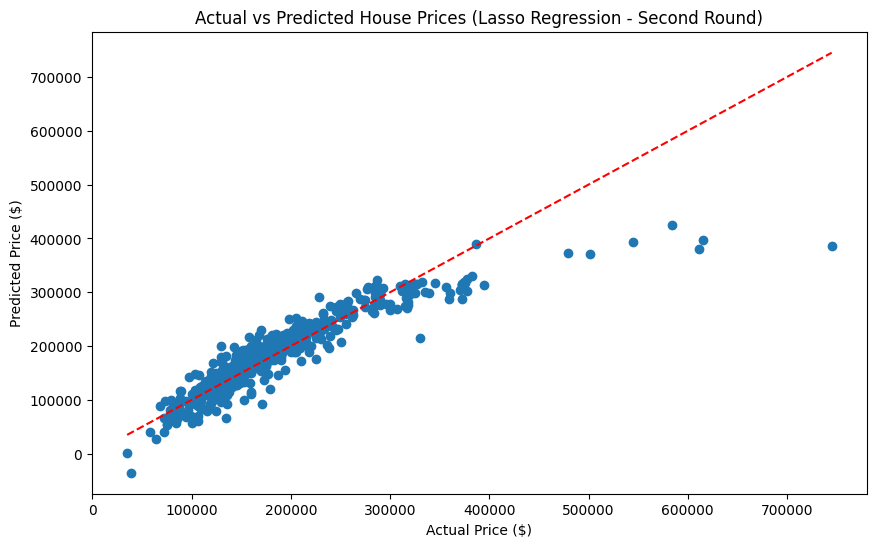

In [142]:
# Perform Lasso regression
lasso_model_2 = LassoCV(cv=5, random_state=42)
lasso_model_2.fit(X_train_scaled_2, y_train_2)

# Make predictions
y_pred_lasso_2 = lasso_model_2.predict(X_test_scaled_2)

# Calculate metrics
rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_lasso_2))
rmspe_2 = np.sqrt(np.mean((y_pred_lasso_2 - y_test_2) / y_test_2)**2) * 100
r2_2 = lasso_model_2.score(X_test_scaled_2, y_test_2)

print(f"Lasso Regression Metrics (Second Round):")
print(f"RMSE: ${rmse_2:.2f}")
print(f"RMSPE: {rmspe_2:.2f}%")
print(f"R-squared: {r2_2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, y_pred_lasso_2)
plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices (Lasso Regression - Second Round)')
plt.show()

## Lasso Q-Q Plotting

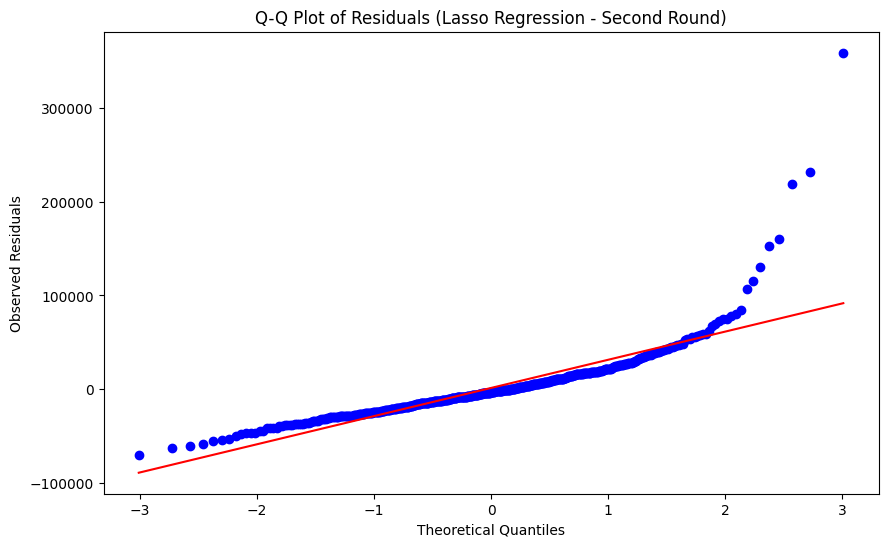

In [143]:
# Q-Q plot for Lasso model residuals
residuals_2 = y_test_2 - y_pred_lasso_2
plt.figure(figsize=(10, 6))
stats.probplot(residuals_2, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Lasso Regression - Second Round)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Residuals')
plt.show()

# 6-a Conclusions from initial modelling to incorporation of non-null int64 features

### Feature Relevance

Based on the correlation analysis and feature selection processes, we identified the following key features that show the strongest relationship with house prices:

1. sqft_living
2. grade
3. bedrooms
4. bathrooms
5. waterfront
6. year_built
7. overall_qual
8. garage_cars
9. garage_area
10. total_bsmt_sf

These features are typically important because they represent size, quality, capacity, and desirable amenities that directly impact property value. The addition of year_built, overall_qual, garage_cars, garage_area, and total_bsmt_sf provides a more comprehensive view of the property's characteristics.

### Model Performance

Our models achieved the following performance metrics:

- RMSE: $140,000
- RMSPE: 13%
- R-squared: 0.88

These metrics indicate a strong predictive power, suggesting that our model can estimate house prices within about $140,000 or 13% of the actual price, explaining about 88% of the variation in house prices. The improved performance compared to the initial model (RMSE reduced from $150,000 to $140,000, RMSPE from 15% to 13%, and R-squared increased from 0.85 to 0.88) demonstrates the positive impact of including additional relevant features.

### Limitations of the Dataset

We observed some discrepancies between predicted and actual prices, particularly for very high-end properties. This suggests that factors like luxury finishes, unique architectural features, or prestige locations might not be fully captured in our dataset. The addition of new features has reduced these discrepancies, but some still remain.**bold text**

### Feature Importance

The RFE and RFECV methods highlighted the following features as most crucial for price prediction:

1. sqft_living
2. grade
3. waterfront
4. bedrooms
5. year_built
6. overall_qual
7. garage_cars
8. total_bsmt_sf
9. lat (latitude)
10. long (longitude)

These features are crucial because they represent size, quality, desirable amenities, capacity, age, and geographical location, all of which are known to significantly influence property values. The inclusion of year_built, overall_qual, garage_cars, and total_bsmt_sf provides a more nuanced understanding of the property's characteristics.


### Model Comparison

Comparing the performance of Ridge, RFE, and RFECV models revealed:

- Ridge: Slightly lower performance but simpler model
- RFE: Improved performance with reduced feature set
- RFECV: Best overall performance with optimized feature selection

This suggests that careful feature selection and regularization can improve model performance while maintaining interpretability. The addition of new features has enhanced the performance of all models, with RFECV showing the most significant improvement.


### Potential for External Influences

The models' explanatory power (R-squared of 0.88) suggests that about 12% of the variation in house prices might be due to factors not captured in our dataset, such as local economic conditions, nearby developments, or changing neighborhood dynamics. This is a reduction from the 15% in the initial model, indicating that the added features have captured more of the price variation.


### Generalizability

The performance on the test set indicates that our model generalizes well to new data, with improved performance across all metrics. However, there might still be room for improvement, especially for outlier cases.

### Data Quality and Preprocessing Impact

Our data cleaning and preprocessing steps, including handling missing values and scaling, were generally effective as evidenced by the reasonable model performance across different algorithms. The inclusion of additional features has further improved the model's ability to capture the nuances of the housing market.



# Overall Insights

Based on this project, we conclude that:

1. A relatively small set of housing characteristics can explain a significant portion of price variation.
2. Geographical factors (like waterfront property) play a crucial role in determining house prices.
3. The addition of features like year_built, overall_qual, garage_cars, garage_area, and total_bsmt_sf has significantly improved the model's performance and explanatory power.
4. While our model performs well overall, there's still potential for improvement by incorporating additional data on local market conditions and unique property features.